<a href="https://colab.research.google.com/github/cric96/FieldKit.scala/blob/master/DL_01_bike_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminary part

## Important imports

library reference:
- [pandas](https://pandas.pydata.org/docs/)
- [matplotlib](https://matplotlib.org/)
- [numpy](https://numpy.org/doc/stable/)
- [sklearn](https://scikit-learn.org/stable/)
- [tensorflow](https://www.tensorflow.org/api_docs)
- [seabord](https://seaborn.pydata.org/)

In [ ]:
import glob 
from datetime import datetime
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import seaborn as sb
from xgboost import XGBRegressor ##Another reference as regressor

seed = 42

## Dataset gathering

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip

!unzip Bike-Sharing-Dataset.zip

--2021-03-17 11:15:53--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279992 (273K) [application/x-httpd-php]
Saving to: ‘Bike-Sharing-Dataset.zip.2’

Bike-Sharing-Datase 100%[===================>] 273.43K  --.-KB/s    in 0.1s    

2021-03-17 11:15:53 (2.38 MB/s) - ‘Bike-Sharing-Dataset.zip.2’ saved [279992/279992]

Archive:  Bike-Sharing-Dataset.zip
replace Readme.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace day.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace hour.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
def plot_history(history,metric=None):
  fig, ax1 = plt.subplots(figsize=(10, 8))

  epoch_count=len(history.history['loss'])

  line1,=ax1.plot(range(1,epoch_count+1),history.history['loss'],label='train_loss',color='orange')
  ax1.plot(range(1,epoch_count+1),history.history['val_loss'],label='val_loss',color = line1.get_color(), linestyle = '--')
  ax1.set_ylim([0, max(max(history.history['loss']),max(history.history['val_loss']))])
  ax1.set_ylabel('loss',color = line1.get_color())
  ax1.tick_params(axis='y', labelcolor=line1.get_color())
  _=ax1.legend(loc='lower left')

  if (metric!=None):
    ax2 = ax1.twinx()
    line2,=ax2.plot(range(1,epoch_count+1),history.history[metric],label='train_'+metric)
    ax2.plot(range(1,epoch_count+1),history.history['val_'+metric],label='val_'+metric,color = line2.get_color(), linestyle = '--')
    ax2.set_xlim([1,epoch_count])
    ax2.set_ylim([0, max(max(history.history[metric]),max(history.history['val_'+metric]))])
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel(metric,color=line2.get_color())
    ax2.tick_params(axis='y', labelcolor=line2.get_color())
    _=ax2.legend(loc='upper right')

def plot_prediction_results(y,y_pred,output_labels,bin_count=50):
  fig, axs = plt.subplots(2,len(output_labels),figsize=(25, 10))
  
  for i in range(len(output_labels)):
    axs[0,i].set_title(output_labels[i])
    axs[0,i].scatter(y[:,i], y_pred[:,i],s=1)
    axs[0,i].set_xlabel('True Values')
    if i==0:
      axs[0,i].set_ylabel('Predictions')
    max_value=max(max(y[:,i]),max(y_pred[:,i]))
    x_lims = [0, max_value]
    y_lims = [min(0,min(y[:,i]),min(y_pred[:,i])), max_value]
    axs[0,i].set_xlim(x_lims)
    axs[0,i].set_ylim(y_lims)
    axs[0,i].plot(y_lims, y_lims, color='k')

    errors = y[:,i]-y_pred[:,i]
    axs[1,i].hist(errors, bins=bin_count)
    axs[1,i].set_xlabel('Prediction Error')
    if i==0:
      axs[1,i].set_ylabel('Count')
    axs[1,i].set_xlim([min(errors),max(errors)])

def plot_prediction_results(y,y_pred,output_labels,bin_count=50):
  fig, axs = plt.subplots(2,len(output_labels),figsize=(25, 10))

  def init_plot(top_plot, bottom_plot):
    top_plot.set_ylabel('Predictions')
    bottom_plot.set_ylabel('Count')
    
  def plot_single(top_plot, bottom_plot, y, y_pred, label):
    top_plot.set_title(label)
    top_plot.scatter(y, y_pred, s = 1)
    top_plot.set_xlabel('True Values')
    
    max_value=max(max(y),max(y_pred))
    x_lims = [0, max_value]
    y_lims = [min(0,min(y),min(y_pred)), max_value]
    top_plot.set_xlim(x_lims)
    top_plot.set_ylim(y_lims)
    top_plot.plot(y_lims, y_lims, color='k')

    errors = y - y_pred
    bottom_plot.hist(errors, bins=bin_count)
    bottom_plot.set_xlabel('Prediction Error')
    bottom_plot.set_xlim([min(errors),max(errors)])

  if len(output_labels) == 1:
    init_plot(axs[0], axs[1])
    plot_single(axs[0], axs[1], y, y_pred, output_labels[0])
  else:
    init_plot(axs[0,0], axs[1,0])
    for i in range(len(output_labels)):
      plot_single(axs[0,i], axs[1, i], y[:,i], y_pred[:,i], output_labels[i])

## Dataset analisys and trasformation
Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return 
back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return 
back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of 
over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, 
environmental and health issues. 

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by
these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration
of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into
a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important
events in the city could be detected via monitoring these data.


**Attributes**
- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit : 
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

The regression target is cnt.


### Basic analysis

In [ ]:
data_set = pd.read_csv("hour.csv", header = 0, encoding = "unicode_escape")

In [ ]:
data_set.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [ ]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


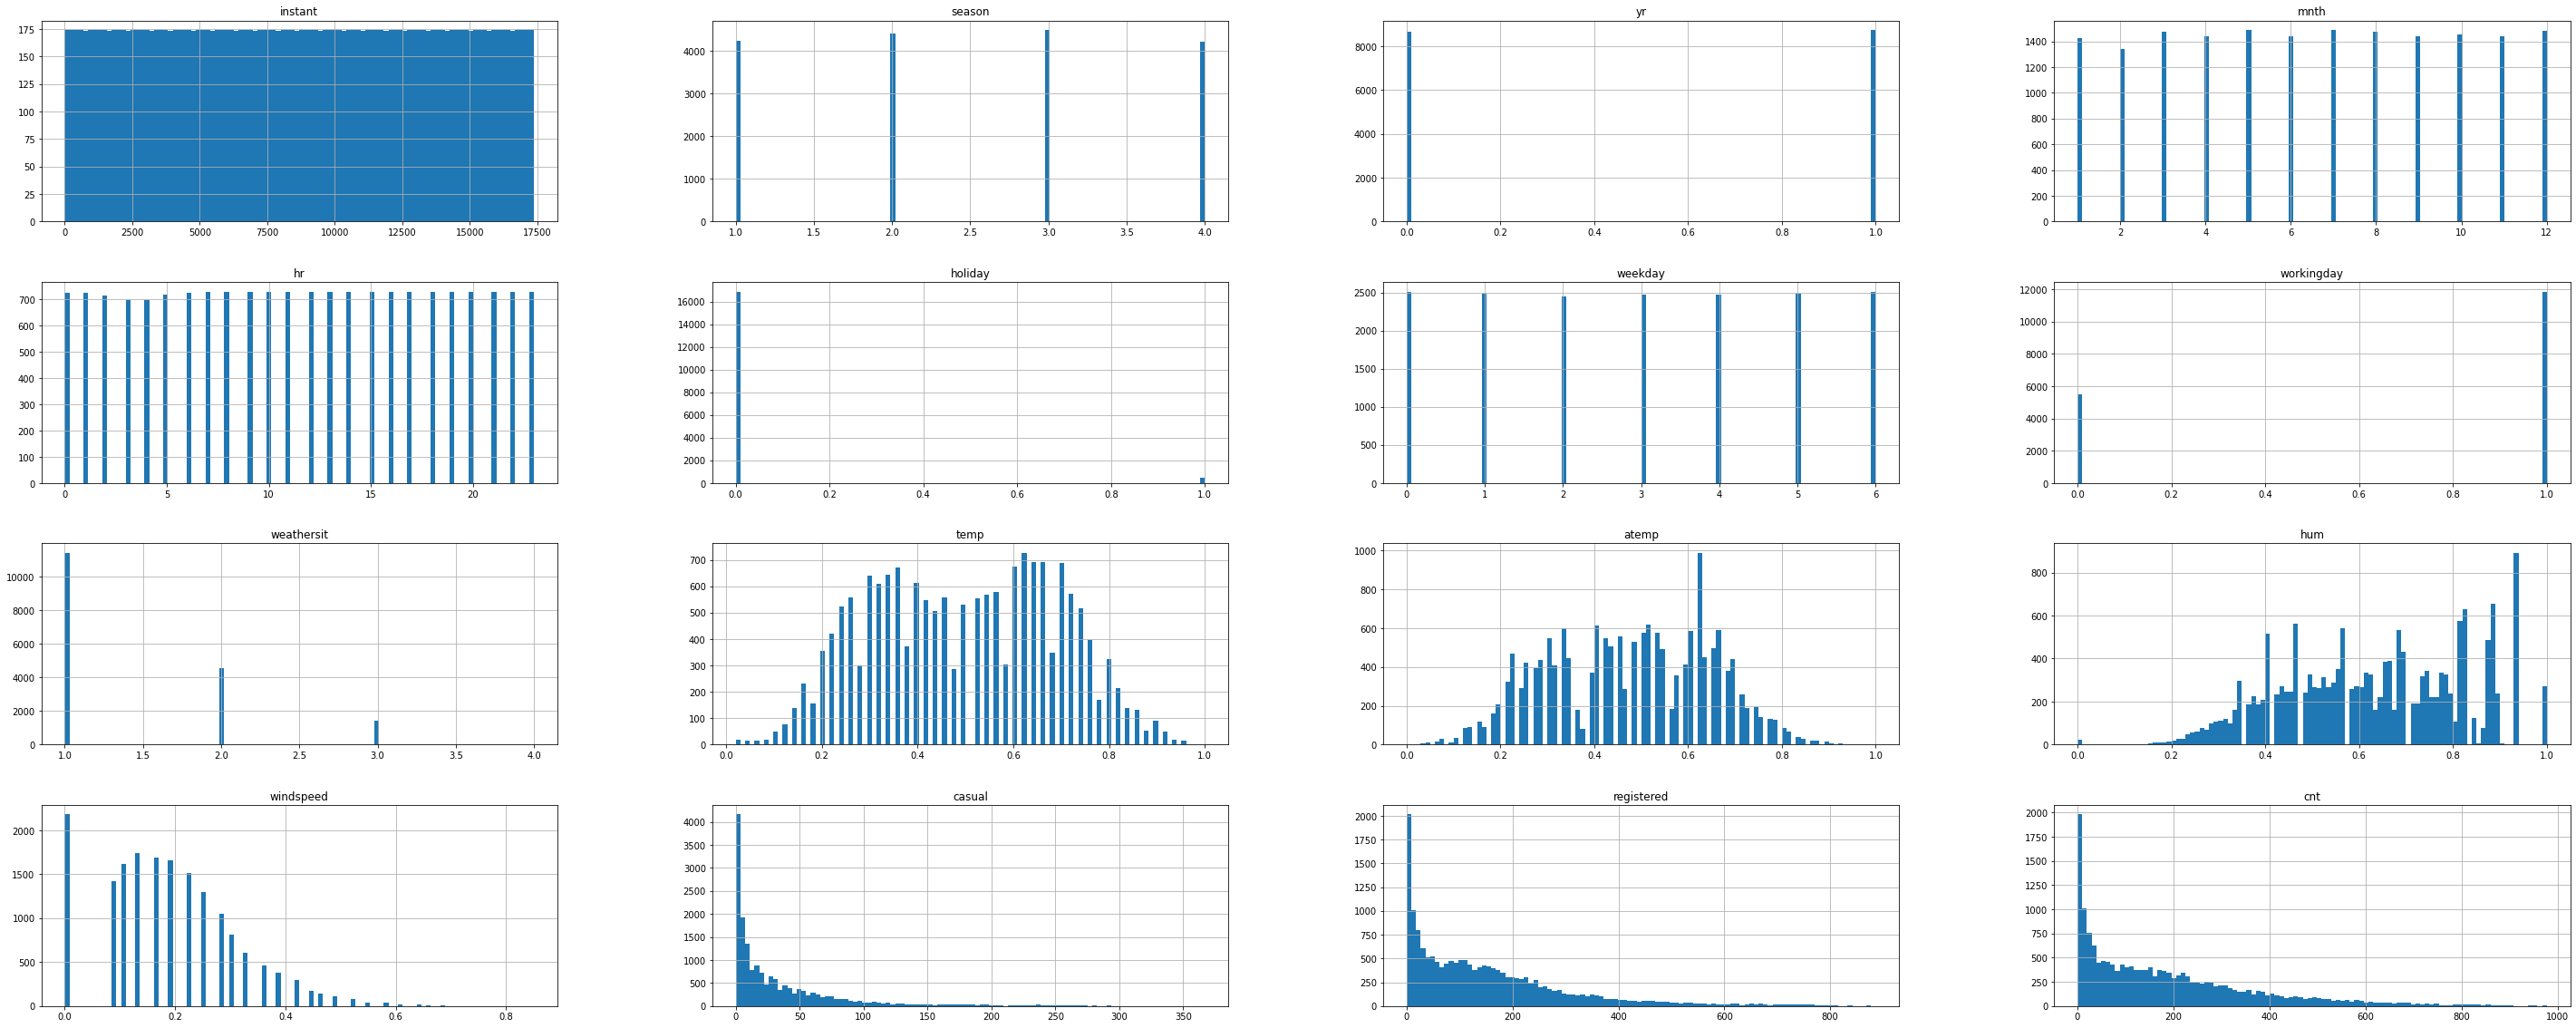

In [ ]:
## Visual information about data
data_set.hist(bins = 100, figsize = (50, 20))
plt.show()

In [ ]:
data_set.columns ## Get all attributes

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8df2243e50>,
      dtype=object)

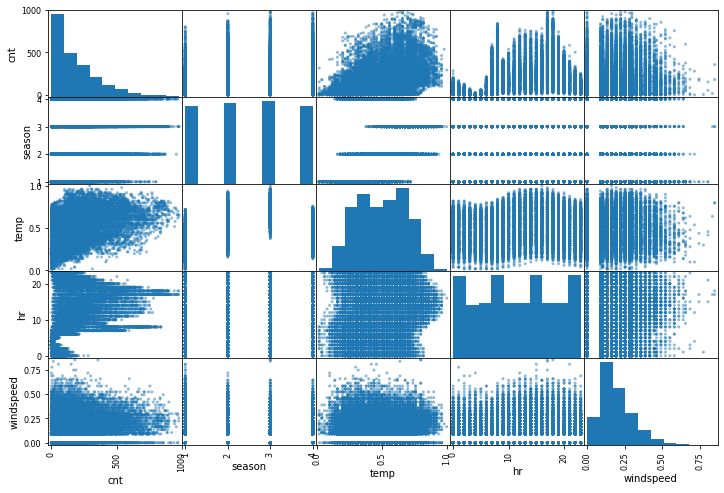

In [ ]:
# Correlation between revelevant data
cor_with_rentend = ["cnt", "season", "temp", "hr", "windspeed"]
scatter_matrix(data_set[cor_with_rentend], figsize = (12, 8))

In [ ]:
corr_matrix = data_set.corr()
corr_matrix["cnt"].sort_values(ascending = False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

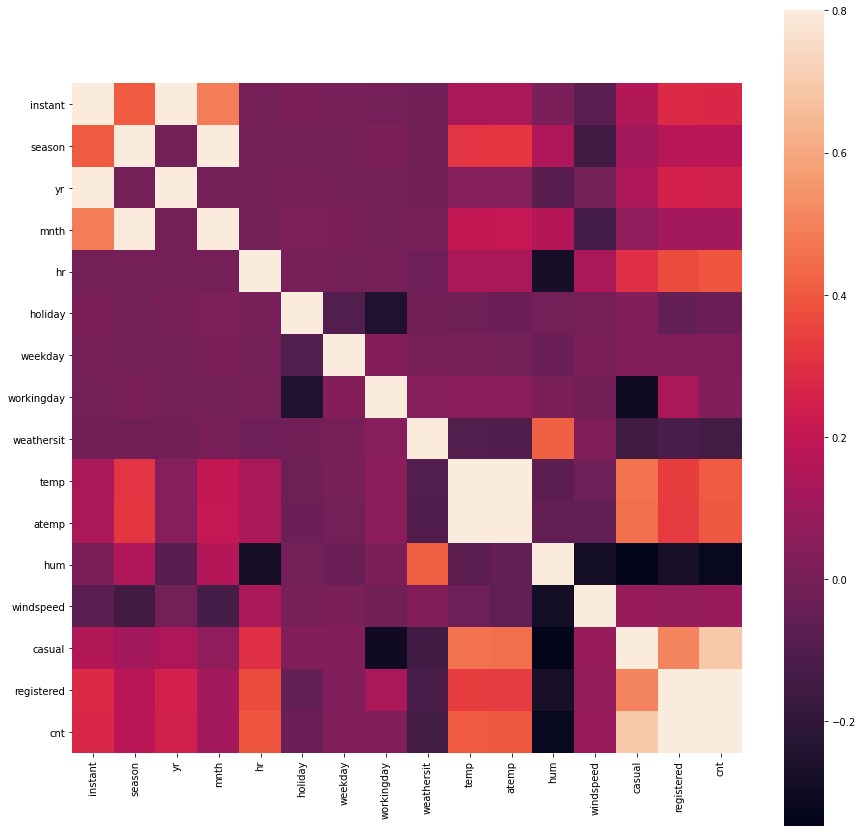

In [ ]:
fig = plt.figure(figsize = (15,15))
sb.heatmap(corr_matrix, vmax = .8, square = True)
plt.show()

## Data cleaning

In [ ]:
reference = data_set
def to_month(date):
  converted = datetime.strptime(date, "%d/%m/%Y")
  return converted.month

if "holiday" in reference.columns:
  reference = reference.drop("holiday", axis = 1)
  reference = reference.drop("dteday", axis = 1)
  reference = reference.drop("atemp", axis = 1)
  reference = reference.drop("instant", axis = 1)
  reference = reference.drop("casual", axis = 1)
  reference = reference.drop("registered", axis = 1)
reference.sample(1)

,season,yr,mnth,hr,weekday,workingday,weathersit,temp,hum,windspeed,cnt
3213,2,0,5,19,3,1,3,0.56,0.88,0.1343,331


# Learninig part


## Data set splitting

In [ ]:
target = ["cnt"]
X = reference.drop(target, axis = 1).values
Y = reference[target].values
test_percentage = 0.25

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = seed, test_size = test_percentage, shuffle = True)

### Scaling the feature

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Reference performance, linear regression

RMSE - Train: 142.299 Test: 141.032
(4345, 1)


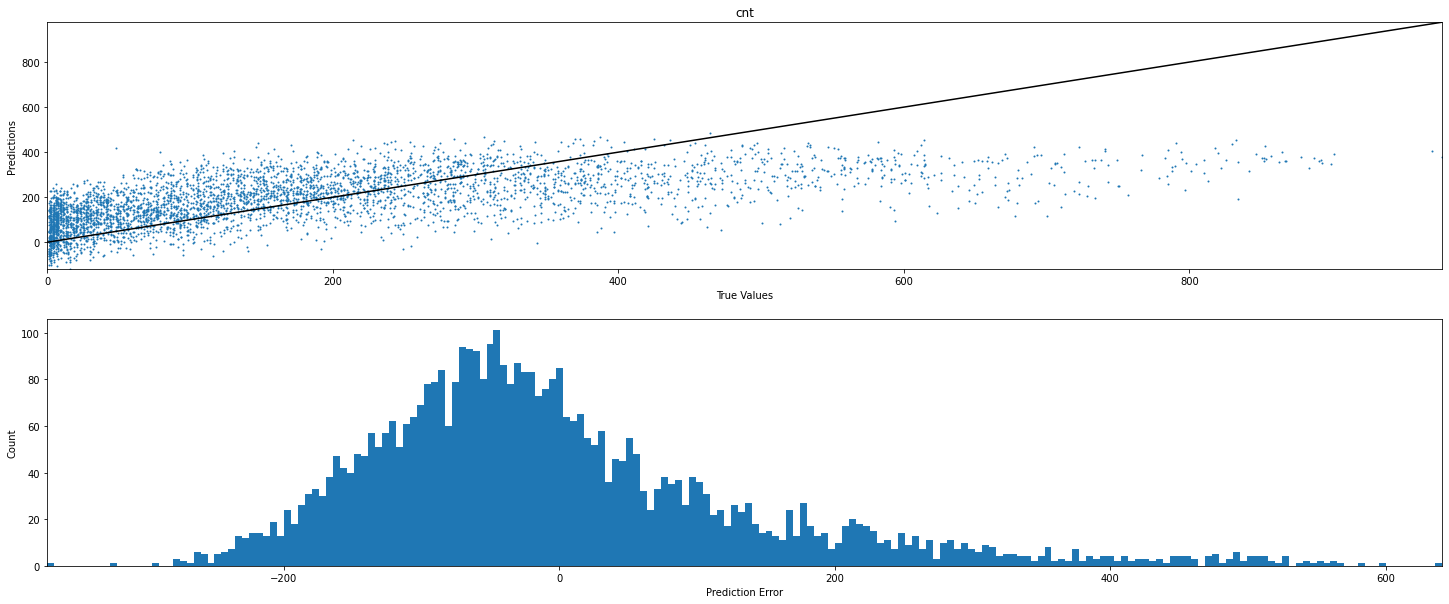

In [ ]:
linear_model = LinearRegression().fit(X_train, Y_train)

rmse_train_error = mean_squared_error(Y_train, linear_model.predict(X_train), squared = False)
rmse_test_error = mean_squared_error(Y_test, linear_model.predict(X_test), squared = False)

print('RMSE - Train: {:.3f} Test: {:.3f}'.format(rmse_train_error, rmse_test_error))
print(linear_model.predict(X_test).shape)
plot_prediction_results(Y_test, linear_model.predict(X_test), target, 200)

## Reference performance, XGB regressor

[11:35:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE - Train: 70.227 Test: 68.988


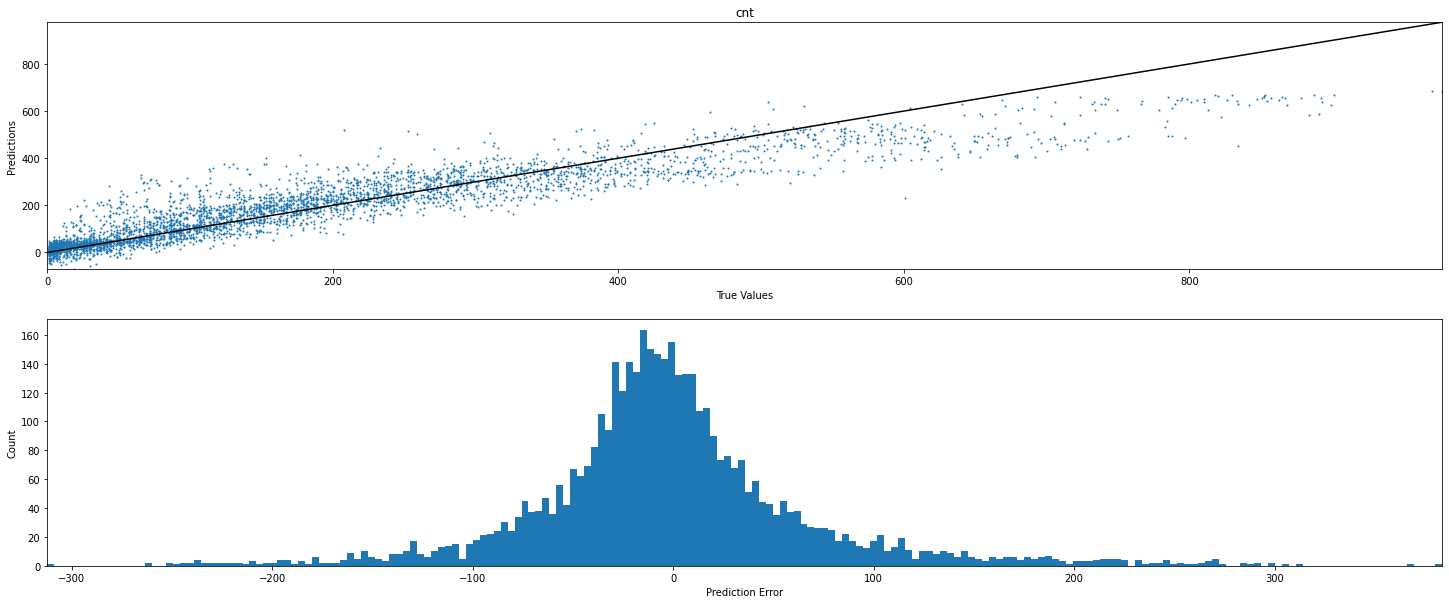

In [ ]:
xgb_regressor = XGBRegressor()
xgb_regressor.fit(X_train, Y_train)
predition = xgb_regressor.predict(X_test)
to_plot = predition.reshape(predition.shape[0], 1)
rmse_train_error = mean_squared_error(Y_train, xgb_regressor.predict(X_train), squared = False)
rmse_test_error = mean_squared_error(Y_test, predition, squared = False)

print('RMSE - Train: {:.3f} Test: {:.3f}'.format(rmse_train_error, rmse_test_error))

plot_prediction_results(Y_test, to_plot, target, 200)

## Deep learning part

### Validation set creation

In [ ]:
val_size = 0.25

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = val_size, random_state = seed,shuffle = True)


In [ ]:
def build_dnn(input_count, output_count, neuron_count_per_hidden_layer = [128, 128], activation='relu'):
  model = keras.Sequential()
  model.add(layers.Input(shape=(input_count)))

  for n in neuron_count_per_hidden_layer:
    
    model.add(layers.Dense(n, activation = activation))

  model.add(layers.Dense(output_count))

  return model

Traning

In [ ]:
epoch_count = 10000
batch_size = 256
sgd_learning_rate = 0.00001
adam_learning_rate = 0.0001
patience = 50
dnn = build_dnn(X_train.shape[1], Y_train.shape[1], [128, 128, 64, 32], activation = 'relu') 
#optimizer = keras.optimizers.SGD(learning_rate = sgd_learning_rate)
#optimizer=keras.optimizers.Adadelta(learning_rate=learning_rate, rho=0.95, epsilon=1e-07, name="Adadelta")
#optimizer=keras.optimizers.Adagrad(learning_rate=learning_rate)
optimizer = keras.optimizers.Adam(learning_rate = adam_learning_rate)
dnn.compile(loss = 'mse', optimizer = optimizer, metrics = [keras.metrics.RootMeanSquaredError(name = 'rmse')])
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = patience, restore_best_weights = True)

history = dnn.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs = epoch_count, batch_size = batch_size, shuffle = True, callbacks= [early_stop])

Epoch 1/10000
39/39 [==============================] - 1s 6ms/step - loss: 69541.2057 - rmse: 263.7020 - val_loss: 70427.6328 - val_rmse: 265.3820
Epoch 2/10000
39/39 [==============================] - 0s 3ms/step - loss: 67698.1714 - rmse: 260.1439 - val_loss: 69987.1094 - val_rmse: 264.5508
Epoch 3/10000
39/39 [==============================] - 0s 4ms/step - loss: 67696.1968 - rmse: 260.1733 - val_loss: 69054.4766 - val_rmse: 262.7822
Epoch 4/10000
39/39 [==============================] - 0s 3ms/step - loss: 67093.5910 - rmse: 259.0163 - val_loss: 67161.7422 - val_rmse: 259.1558
Epoch 5/10000
39/39 [==============================] - 0s 4ms/step - loss: 64401.8281 - rmse: 253.7670 - val_loss: 63613.1953 - val_rmse: 252.2166
Epoch 6/10000
39/39 [==============================] - 0s 3ms/step - loss: 59803.8991 - rmse: 244.5410 - val_loss: 57634.3477 - val_rmse: 240.0715
Epoch 7/10000
39/39 [==============================] - 0s 3ms/step - loss: 54869.8746 - rmse: 234.1793 - val_loss: 490

### Evaluation

RMSE - Train: 33.455 Val: 44.474 Test: 44.580


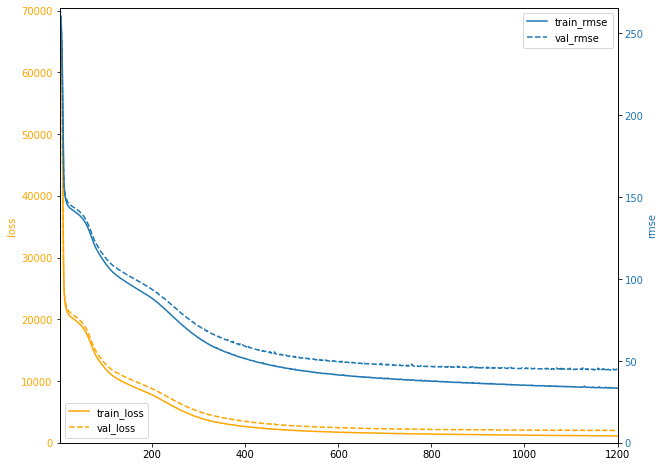

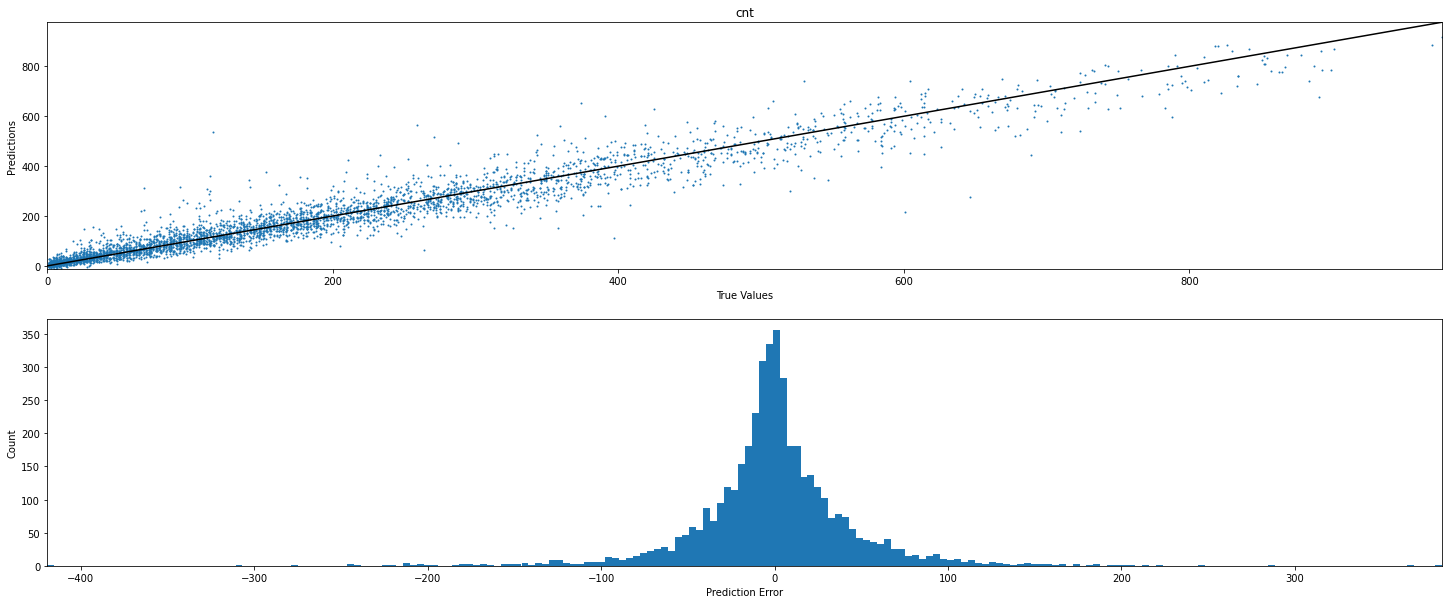

In [ ]:
Y_train_pred = dnn.predict(X_train)
Y_val_pred = dnn.predict(X_val)
Y_test_pred = dnn.predict(X_test)

plot_history(history, 'rmse')
plot_prediction_results(Y_test, Y_test_pred, target, 200)

rmse_train = mean_squared_error(Y_train ,Y_train_pred, squared = False)
rmse_val = mean_squared_error(Y_val, Y_val_pred, squared = False)
rmse_test = mean_squared_error(Y_test, Y_test_pred, squared = False)

print('RMSE - Train: {:.3f} Val: {:.3f} Test: {:.3f}'.format(rmse_train,rmse_val,rmse_test))

In [ ]:
rmse_test_instances = np.sqrt(mean_squared_error(Y_test.transpose(),Y_test_pred.transpose(),multioutput='raw_values'))

rmse_test_instances_sorted_indices = np.argsort(rmse_test_instances)

row_count = 5

print("Best..")
with np.printoptions(precision = 1, suppress = True):
  print('RMSE:')
  print(rmse_test_instances[rmse_test_instances_sorted_indices[:row_count]])

  print('True values:')
  print(Y_test[rmse_test_instances_sorted_indices[:row_count]])

  print('Predicted values:')
  print(Y_test_pred[rmse_test_instances_sorted_indices[:row_count]])


print("Worst...")

with np.printoptions(precision = 1, suppress = True):
  print('RMSE:')
  print(rmse_test_instances[rmse_test_instances_sorted_indices[-row_count:]])

  print('True values:')
  print(Y_test[rmse_test_instances_sorted_indices[-row_count:]])

  print('Predicted values:')
  print(Y_test_pred[rmse_test_instances_sorted_indices[-row_count:]])

Best..
RMSE:
[0. 0. 0. 0. 0.]
True values:
[[236]
 [120]
 [519]
 [  1]
 [145]]
Predicted values:
[[236.]
 [120.]
 [519.]
 [  1.]
 [145.]]
Worst...
RMSE:
[284.7 307.2 368.1 384.9 419.3]
True values:
[[397]
 [259]
 [646]
 [601]
 [116]]
Predicted values:
[[112.3]
 [566.2]
 [277.9]
 [216.1]
 [535.3]]
